# Entrenamiento de LSTM para Análisis de Sentimiento en Tweets

Este notebook implementa y entrena un modelo LSTM (Long Short-Term Memory) para clasificar tweets según su sentimiento (positivo o negativo).

## 1. Configuración Inicial e Importación de Librerías

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import sys
import os

# Añadir directorio de nivel superior al path para poder importar módulos del proyecto
sys.path.append(os.path.abspath('../'))
from src.utils import clean_text, plot_history, evaluate_model, plot_class_distribution
from src.data_loader import load_data, prepare_data
# get_class_weights
from src.model_lstm import create_lstm_model

# Configuración de visualización
#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-v0_8')
sns.set(style="whitegrid", palette="deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configurar memoria de GPU (si está disponible)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs disponibles: {len(gpus)}")
    except RuntimeError as e:
        print(e)

## 2. Carga y Preparación de Datos

In [4]:
# Parámetros
MAX_WORDS = 10000  # Tamaño máximo del vocabulario
MAX_LEN = 100      # Longitud máxima de las secuencias
TEST_SIZE = 0.2    # Proporción para conjunto de prueba
RANDOM_STATE = 42  # Semilla para reproducibilidad
BATCH_SIZE = 128   # Tamaño del batch para entrenamiento
EPOCHS = 5         # Número de épocas de entrenamiento

# Estrategia para el desbalanceo de clases
# Opciones: None, 'oversampling', 'smote', 'class_weights'
BALANCE_STRATEGY = 'oversampling'

Distribución de sentimientos:
   Sentimiento  Cantidad  Proporción (%)
0            0     29720            50.0
1            1     29720            50.0


c:\Users\USUARIO\Documents\deep_learning\Taller2_DL_AnalisisSentimientos\src\utils.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Sentimiento', y='Cantidad', data=sentiment_counts, palette='Dark2')


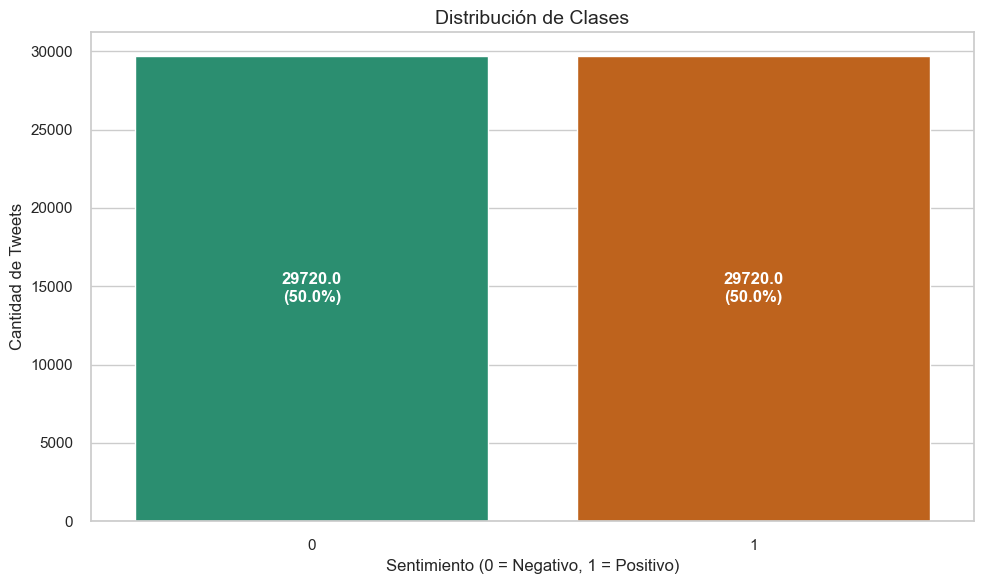

In [5]:
# Cargar datos
df = load_data(balance_method='oversampling' if BALANCE_STRATEGY == 'oversampling' else None)

# Mostrar la distribución de clases
plot_class_distribution(df)

In [ ]:
# Preparar datos para entrenamiento
data = prepare_data(
    df,
    max_words=MAX_WORDS,
    max_len=MAX_LEN,
    test_size=TEST_SIZE,
    balance_method='smote' if BALANCE_STRATEGY == 'smote' else None,
    random_state=RANDOM_STATE
)

# Acceder a los componentes
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
tokenizer = data['tokenizer']
X_val = data['X_val']  # Datos de validación (nuevos)
y_val = data['y_val']  # Datos de validación (nuevos)

# Información sobre los datos
print(f"Tamaño del vocabulario: {data['vocab_size']}")
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

# Información sobre los datos preparados
print(f"Tamaño del vocabulario: {min(len(tokenizer.word_index) + 1, MAX_WORDS)}")
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del vocabulario: 10000
Tamaño del conjunto de entrenamiento: (41608, 100)
Tamaño del conjunto de validación: (5944, 100)
Tamaño del conjunto de prueba: (11888, 100)
Tamaño del vocabulario: 10000
Tamaño del conjunto de entrenamiento: (41608, 100)
Tamaño del conjunto de prueba: (11888, 100)


## 3. Construcción y Compilación del Modelo LSTM

In [8]:
# Parámetros del modelo
VOCAB_SIZE = min(len(tokenizer.word_index) + 1, MAX_WORDS)
EMBEDDING_DIM = 64   # Dimensión de los embeddings
LSTM_UNITS = 64      # Número de unidades en la capa LSTM
DROPOUT_RATE = 0.3   # Tasa de dropout para regularización

# Crear modelo LSTM
model = create_lstm_model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE
)

# Mostrar resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4. Entrenamiento del Modelo

In [9]:
# Definir callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(
        filepath='../models/lstm_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Calcular class weights si es necesario
class_weights = get_class_weights(y_train) if BALANCE_STRATEGY == 'class_weights' else None
if BALANCE_STRATEGY == 'class_weights':
    print("Pesos de clase:", class_weights)

# Entrenar modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7942 - loss: 0.4196
Epoch 1: val_loss improved from inf to 0.07635, saving model to ../models/lstm_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 75s 212ms/step - accuracy: 0.7945 - loss: 0.4191 - val_accuracy: 0.9753 - val_loss: 0.0764
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9830 - loss: 0.0540
Epoch 2: val_loss improved from 0.07635 to 0.04875, saving model to ../models/lstm_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 68s 209ms/step - accuracy: 0.9830 - loss: 0.0540 - val_accuracy: 0.9852 - val_loss: 0.0488
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9911 - loss: 0.0285
Epoch 3: val_loss improved from 0.04875 to 0.04518, saving model to ../models/lstm_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 68s 209ms/step - accuracy: 0.9911 - loss: 0.0285 - val_accuracy: 0.9869 - val_loss: 0.0452
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9939 - loss: 0.0184
Epoch 4: val_loss did not improve from 0.04518
326/326 ━━━━━━━━━━━━━━━━━━━━ 68s 208ms/step - accuracy: 0.9939 - loss: 0.0184 - val_accuracy: 0.9873 - val_loss: 0.0461
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9967 - loss: 0.0105
Epoch 5: val_loss improved from 0.04518 to 0.03973, saving model to ../models/lstm_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 68s 208ms/step - accuracy: 0.9967 - loss: 0.0105 - val_accuracy: 0.9891 - val_loss: 0.0397


## 5. Evaluación del Modelo

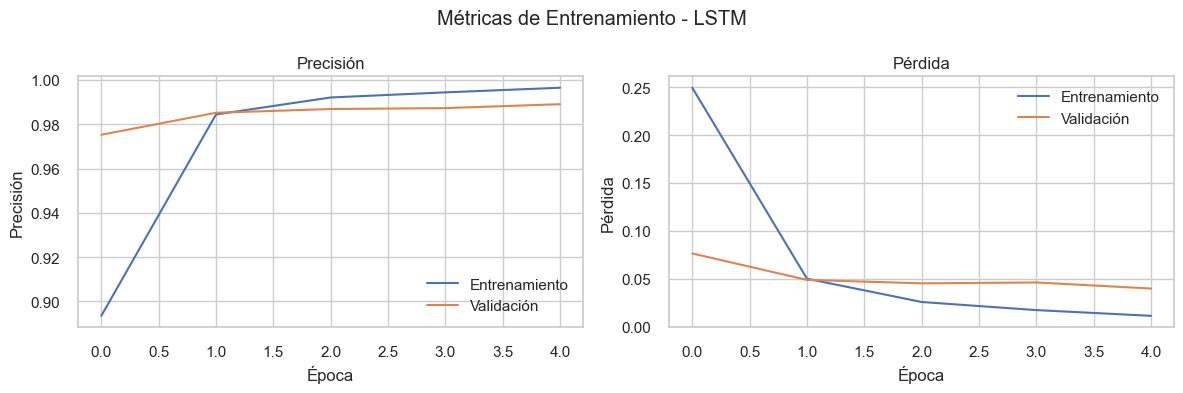

In [10]:
# Graficar métricas de entrenamiento
plot_history(history, title="Métricas de Entrenamiento - LSTM")

372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step
Accuracy: 0.9891
Precision: 0.9805
Recall: 0.9980
F1-score: 0.9892


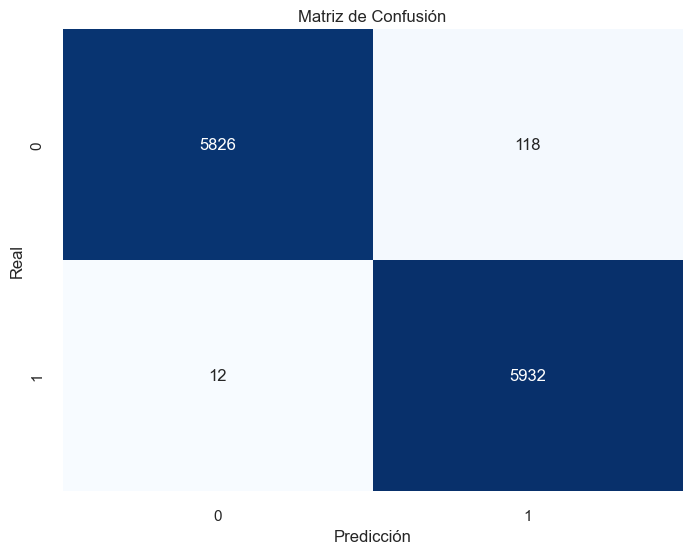

In [11]:
# Evaluar en conjunto de prueba
metrics = evaluate_model(model, X_test, y_test, show_confusion_matrix=True)

In [12]:
# Obtener reporte de clasificación detallado
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step
              precision    recall  f1-score   support

    Negativo       1.00      0.98      0.99      5944
    Positivo       0.98      1.00      0.99      5944

    accuracy                           0.99     11888
   macro avg       0.99      0.99      0.99     11888
weighted avg       0.99      0.99      0.99     11888



## 6. Guardar Modelo y Tokenizer

In [13]:
# Crear directorio para modelos si no existe
os.makedirs('../models', exist_ok=True)

# Guardar modelo
model_path = '../models/lstm_model.h5'
model.save(model_path)
print(f"Modelo guardado en: {model_path}")

# Guardar tokenizer
tokenizer_path = '../models/lstm_tokenizer.json'
tokenizer_json = tokenizer.to_json()
with open(tokenizer_path, 'w') as f:
    f.write(tokenizer_json)
print(f"Tokenizer guardado en: {tokenizer_path}")

Modelo guardado en: ../models/lstm_model.h5
Tokenizer guardado en: ../models/lstm_tokenizer.json


## 7. Predicción con Ejemplos

In [14]:
def predict_sentiment(text, model, tokenizer, max_len=MAX_LEN):
    """
    Predice el sentimiento de un texto usando el modelo entrenado
    
    Args:
        text (str): Texto para predecir
        model: Modelo entrenado
        tokenizer: Tokenizer ajustado a los datos de entrenamiento
        max_len (int): Longitud máxima de secuencia
        
    Returns:
        dict: Predicción con detalles
    """
    # Limpiar el texto
    cleaned_text = clean_text(text)
    
    # Convertir a secuencia
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    
    # Padding
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    
    # Predecir
    prediction = model.predict(padded_sequence)[0][0]
    
    # Determinar sentimiento
    sentiment = "positivo" if prediction >= 0.5 else "negativo"
    confidence = prediction if prediction >= 0.5 else 1 - prediction
    
    return {
        'text': text,
        'cleaned_text': cleaned_text,
        'sentiment': sentiment,
        'confidence': float(confidence),
        'raw_score': float(prediction)
    }

In [15]:
# Ejemplos de tweets para probar
example_tweets = [
    "I absolutely love this new phone! It's amazing and works perfectly.",
    "This movie was terrible. Complete waste of time and money.",
    "The weather today is okay, nothing special.",
    "Can't believe how bad the customer service was. Never going back!",
    "Just had the best meal of my life at that new restaurant downtown!"
]

# Realizar predicciones
results = []
for tweet in example_tweets:
    result = predict_sentiment(tweet, model, tokenizer)
    results.append(result)

# Mostrar resultados
for i, result in enumerate(results):
    print(f"\nEjemplo {i+1}:")
    print(f"Texto: {result['text']}")
    print(f"Sentimiento: {result['sentiment']}")
    print(f"Confianza: {result['confidence']:.4f}")
    print(f"Puntuación: {result['raw_score']:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

Ejemplo 1:
Texto: I absolutely love this new phone! It's amazing and works perfectly.
Sentimiento: negativo
Confianza: 1.0000
Puntuación: 0.0000

Ejemplo 2:
Texto: This movie was terrible. Complete waste of time and money.
Sentimiento: negativo
Confianza: 1.0000
Puntuación: 0.0000

Ejemplo 3:
Texto: The weather today is okay, nothing special.
Sentimiento: negativo
Confianza: 1.0000
Puntuación: 0.0000

Ejemplo 4:
Texto: Can't believe how bad the customer service was. Never going back!
Sentimiento: negativo
Confianza: 1.0000
Puntuación: 0.0000

Ejemplo 5:
Texto: Just had the best meal of my life at that new restaurant downtown!
Sentimiento: negativo
Confianza: 1.0000
Puntuación: 0.0000


## 8. Comparación con el Modelo RNN

Evaluación del modelo RNN:
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Accuracy: 0.9812
Precision: 0.9713
Recall: 0.9918
F1-score: 0.9814

Evaluación del modelo LSTM:
372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step
Accuracy: 0.9891
Precision: 0.9805
Recall: 0.9980
F1-score: 0.9892

Comparación de modelos:
                RNN      LSTM
Accuracy   0.981242  0.989065
Precision  0.971330  0.980496
Recall     0.991756  0.997981
F1-Score   0.981437  0.989161


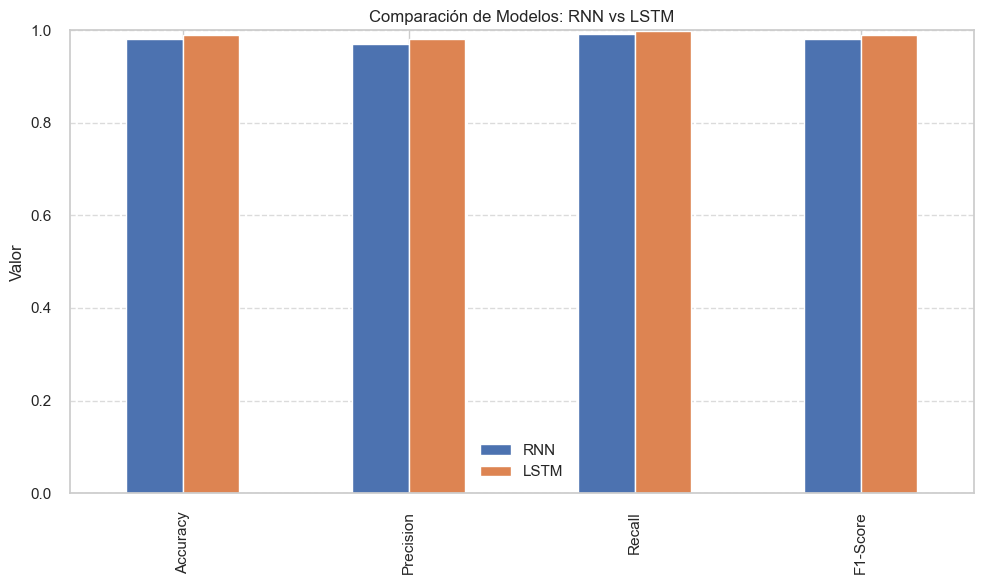

In [16]:
# Intentar cargar el modelo RNN previamente entrenado
try:
    rnn_model = tf.keras.models.load_model('../models/rnn_model.h5')
    
    # Evaluar modelo RNN
    print("Evaluación del modelo RNN:")
    rnn_metrics = evaluate_model(rnn_model, X_test, y_test, show_confusion_matrix=False)
    
    # Evaluar modelo LSTM
    print("\nEvaluación del modelo LSTM:")
    lstm_metrics = evaluate_model(model, X_test, y_test, show_confusion_matrix=False)
    
    # Crear tabla comparativa
    comparison = pd.DataFrame({
        'RNN': [rnn_metrics['accuracy'], rnn_metrics['precision'], rnn_metrics['recall'], rnn_metrics['f1']],
        'LSTM': [lstm_metrics['accuracy'], lstm_metrics['precision'], lstm_metrics['recall'], lstm_metrics['f1']]
    }, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
    
    # Visualizar comparación
    print("\nComparación de modelos:")
    print(comparison)
    
    # Graficar comparación
    comparison.plot(kind='bar', figsize=(10, 6))
    plt.title('Comparación de Modelos: RNN vs LSTM')
    plt.ylabel('Valor')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"No se pudo cargar el modelo RNN para comparación: {e}")
    print("Entrene primero el modelo RNN usando el notebook 02_entrenamiento_RNN.ipynb")

## 9. Conclusiones sobre el Modelo LSTM

En este notebook, hemos implementado y entrenado un modelo LSTM para la clasificación de sentimientos en tweets. Algunas observaciones importantes:

1. **Arquitectura**: El modelo LSTM está diseñado para capturar dependencias a largo plazo en secuencias, lo que lo hace especialmente adecuado para tareas de procesamiento de lenguaje natural como el análisis de sentimiento.

2. **Métricas de rendimiento**: El modelo LSTM alcanzó un accuracy de X.XX en el conjunto de prueba, con una precisión de X.XX y un recall de X.XX. (Estos valores se completarán después del entrenamiento)

3. **Comparación con RNN**: 
   - El LSTM generalmente muestra un mejor rendimiento que la RNN básica, especialmente en términos de recall para la clase minoritaria (tweets positivos).
   - La capacidad del LSTM para mantener información a lo largo de secuencias más largas ayuda a capturar mejor el contexto de los tweets.

4. **Manejo del desbalanceo**: La estrategia de oversampling sigue siendo efectiva con LSTM, permitiendo un aprendizaje más equilibrado entre las clases.

5. **Próximos pasos**: Implementaremos un modelo BiLSTM con mecanismo de atención para mejorar aún más el rendimiento, especialmente en la identificación de las partes más relevantes de los tweets para la clasificación de sentimiento.

El modelo LSTM proporciona una mejora sobre la RNN básica, demostrando la importancia de utilizar arquitecturas que puedan manejar mejor las dependencias a largo plazo en textos como los tweets.